In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit, logit, comb
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

import sys
sys.path.append('../utils/')
import psix_functions as px
%run -i '~/psix/data_analysis/analysis_utils.py'
%run -i '~/sc_splicing_regulation/utils/utils_functions.py'

100%|██████████| 202/202 [00:02<00:00, 89.02it/s]


In [27]:
# chen_kw2, chen_kw_1, chen_kw_25, chen_elife = get_elife_tests(chen_rd, chen_PSI, 
#                                                             chen_mrna_event, chen_psix, n_clusters = 5)

In [7]:
chen_reads = pd.read_csv('~/data_sc_regulation/chen_extended/skipped_exons_SJreads.tab', sep='\t',
                            index_col = 0)
chen_reads = chen_reads.loc[chen_PSI.index & chen_reads.index, chen_PSI.columns]

chen_reads_adj = chen_reads/(1+chen_PSI)

song_reads = pd.read_csv('~/data_sc_regulation/song/skipped_exons_SJreads.tab', sep='\t',
                            index_col = 0)
song_reads = song_reads.loc[song_PSI.index, song_PSI.columns]

song_reads_adj = song_reads/(1+song_PSI)

tiklova_reads = pd.read_csv('~/data_sc_regulation/tiklova_extended/skipped_exons_SJreads.tab', sep='\t',
                            index_col = 0)
tiklova_reads = tiklova_reads.loc[tiklova_PSI.index, tiklova_PSI.columns]

tiklova_reads_adj = tiklova_reads/(1+tiklova_PSI)

In [2]:
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/sc_splicing_regulation/utils/')
from utils_functions import *

hubbard_pvals = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Hubbard_pvals.tab', sep='\t', index_col=0)
hubbard_fdr = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Hubbard_fdr.tab', sep='\t', index_col=0)
hubbard_psi = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Hubbard_psi.tab', sep='\t', index_col=0)

hubbard_ds = get_averages_bulk(hubbard_psi)
chen_kw_scores = pd.read_csv('~/sc_splicing_regulation/sc_neurogenesis/chen_kw.tab', 
                                sep='\t', index_col=0)

song_bulk_pvals = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/song_bulk_pvals.tab', sep='\t', index_col=0)
song_bulk_fdr = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/song_bulk_fdr.tab', sep='\t', index_col=0)
song_bulk_psi = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/song_bulk_psi.tab', sep='\t', index_col=0)

song_bulk_ds = get_averages_bulk(song_bulk_psi)
song_kw_scores = pd.read_csv('~/sc_splicing_regulation/sc_neurogenesis/song_kw.tab', 
                                sep='\t', index_col=0)

weyn_pvals = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_pvals.tab', sep='\t', index_col=0)
weyn_fdr = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_fdr.tab', sep='\t', index_col=0)
weyn_psi = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_psi.tab', sep='\t', index_col=0)

weyn_ds = get_averages_bulk(weyn_psi)
tiklova_kw_scores = pd.read_csv('~/sc_splicing_regulation/sc_neurogenesis/tiklova_neurogenesis_kw.tab', 
                                sep='\t', index_col=0)

In [3]:
tiklova_geary = pd.read_csv(
    '~/sc_splicing_regulation/sc_neurogenesis/tiklova_neurogenesis_autocorr/tiklova_GearyC_k100.tab',
    sep='\t', index_col=0)
chen_geary = pd.read_csv('~/sc_splicing_regulation/sc_neurogenesis/chen_autocor/chen_GearyC_k30.tab',
    sep='\t', index_col=0)
song_geary = pd.read_csv('~/sc_splicing_regulation/sc_neurogenesis/song_autocor/song_GearyC_k30.tab',
    sep='\t', index_col=0)

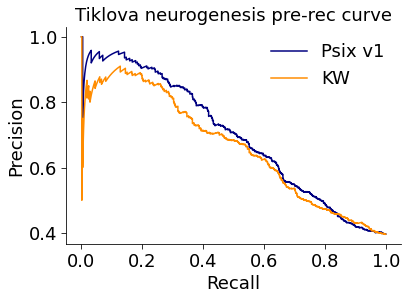

In [10]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

# figsize(7, 5)

fig = plt.figure()
ax  = plt.subplot(1,1,1)

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index
y1 = [1]*len(weyn_pos & exons) + [0]*len(weyn_neg & exons)
L_score_y = list(tiklova_psix.loc[weyn_pos & exons].L_score) + list(tiklova_psix.loc[weyn_neg & exons].L_score)
# psix_v2_y = list(tiklova_psix.loc[weyn_pos & exons].psix_v2) + list(tiklova_psix.loc[weyn_neg & exons].psix_v2)
kw_y = list(tiklova_kw.loc[weyn_pos & exons].KW_score) + list(tiklova_kw.loc[weyn_neg & exons].KW_score)

pre1, rec1, thres1 = precision_recall_curve(y1, L_score_y)
# pre2, rec2, thres2 = precision_recall_curve(y1, psix_v2_y)
pre3, rec3, thres3 = precision_recall_curve(y1, kw_y)

plt.plot(rec1, pre1, c='navy', label='Psix v1')
# plt.plot(rec2, pre2, c='forestgreen', label='Psix v2')
plt.plot(rec3, pre3, c='darkorange', label='KW')

plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=18, length=5)
plt.title('Tiklova neurogenesis pre-rec curve', fontsize=18)
plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
plt.legend(frameon=False, fontsize=18)

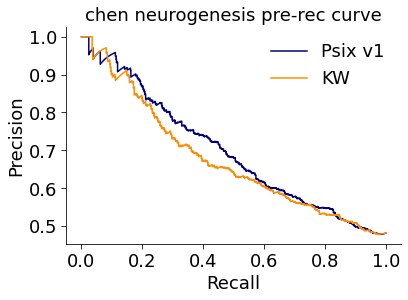

In [5]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

# figsize(7, 5)

fig = plt.figure()
ax  = plt.subplot(1,1,1)

hubbard_pos = hubbard_fdr.index[(hubbard_ds.max(axis=1) >= 0.2) & (hubbard_fdr.min(axis=1) <= 0.05)]
hubbard_neg = hubbard_fdr.index[(hubbard_ds.max(axis=1) < 0.2) | (hubbard_fdr.min(axis=1) > 0.05)]

exons = chen_psix.index
y1 = [1]*len(hubbard_pos & exons) + [0]*len(hubbard_neg & exons)
L_score_y = list(chen_psix.loc[hubbard_pos & exons].L_score) + list(chen_psix.loc[hubbard_neg & exons].L_score)
# psix_v2_y = list(chen_psix.loc[hubbard_pos & exons].psix_v2) + list(chen_psix.loc[hubbard_neg & exons].psix_v2)
kw_y = list(chen_kw.loc[hubbard_pos & exons].KW_score) + list(chen_kw.loc[hubbard_neg & exons].KW_score)

pre1, rec1, thres1 = precision_recall_curve(y1, L_score_y)
# pre2, rec2, thres2 = precision_recall_curve(y1, psix_v2_y)
pre3, rec3, thres3 = precision_recall_curve(y1, kw_y)

plt.plot(rec1, pre1, c='navy', label='Psix v1')
# plt.plot(rec2, pre2, c='forestgreen', label='Psix v2')
plt.plot(rec3, pre3, c='darkorange', label='KW')

plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=18, length=5)
plt.title('chen neurogenesis pre-rec curve', fontsize=18)
plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
plt.legend(frameon=False, fontsize=18)

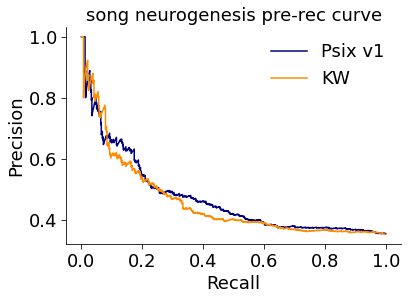

In [6]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

# figsize(7, 5)

fig = plt.figure()
ax  = plt.subplot(1,1,1)

song_bulk_pos = song_bulk_fdr.index[(song_bulk_ds.max(axis=1) >= 0.2) & (song_bulk_fdr.min(axis=1) <= 0.05)]
song_bulk_neg = song_bulk_fdr.index[(song_bulk_ds.max(axis=1) < 0.2) | (song_bulk_fdr.min(axis=1) > 0.05)]

exons = song_psix.index
y1 = [1]*len(song_bulk_pos & exons) + [0]*len(song_bulk_neg & exons)
L_score_y = list(song_psix.loc[song_bulk_pos & exons].L_score) + list(song_psix.loc[song_bulk_neg & exons].L_score)
# psix_v2_y = list(song_psix.loc[song_bulk_pos & exons].psix_v2) + list(song_psix.loc[song_bulk_neg & exons].psix_v2)
kw_y = list(song_kw.loc[song_bulk_pos & exons].KW_score) + list(song_kw.loc[song_bulk_neg & exons].KW_score)

pre1, rec1, thres1 = precision_recall_curve(y1, L_score_y)
# pre2, rec2, thres2 = precision_recall_curve(y1, psix_v2_y)
pre3, rec3, thres3 = precision_recall_curve(y1, kw_y)

plt.plot(rec1, pre1, c='navy', label='Psix v1')
# plt.plot(rec2, pre2, c='forestgreen', label='Psix v2')
plt.plot(rec3, pre3, c='darkorange', label='KW')

plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=18, length=5)
plt.title('song neurogenesis pre-rec curve', fontsize=18)
plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
plt.legend(frameon=False, fontsize=18)

In [7]:
# tiklova_kw_scores_clusters = pd.DataFrame()
# chen_kw_scores_clusters = pd.DataFrame()
# song_kw_scores_clusters = pd.DataFrame()
# for n_clusters in tqdm(np.arange(2, 11)):
#     chen_kw_scores, chen_kw_1, chen_kw_25, chen_elife = get_elife_tests(chen_rd, chen_PSI, 
#                                                             chen_mrna_event, chen_psix, n_clusters = n_clusters)
#     chen_kw_scores_clusters['cluster_'+str(n_clusters)] = chen_kw_scores.KW_score
    
#     tiklova_kw_scores, tiklova_kw_1, tiklova_kw_25, tiklova_elife = get_elife_tests(tiklova_rd, tiklova_PSI, 
#                                                             tiklova_mrna_event, tiklova_psix, n_clusters = n_clusters)
#     tiklova_kw_scores_clusters['cluster_'+str(n_clusters)] = tiklova_kw_scores.KW_score
    
#     song_kw_scores, song_kw_1, song_kw_25, song_elife = get_elife_tests(song_rd, song_PSI, 
#                                                             song_mrna_event, song_psix, n_clusters = n_clusters)
#     song_kw_scores_clusters['cluster_'+str(n_clusters)] = song_kw_scores.KW_score
    
#     chen_kw_scores_clusters.index = chen_kw_scores.index
#     tiklova_kw_scores_clusters.index = tiklova_kw_scores.index
#     song_kw_scores_clusters.index = song_kw_scores.index
    
    
# tiklova_kw_scores_clusters.to_csv('~/tiklova_kw_clusters.tab', sep='\t', index=True, header=True)
# chen_kw_scores_clusters.to_csv('~/chen_kw_clusters.tab', sep='\t', index=True, header=True)
# song_kw_scores_clusters.to_csv('~/song_kw_clusters.tab', sep='\t', index=True, header=True)

100%|██████████| 9/9 [34:42<00:00, 231.39s/it]


In [ ]:
L_list = []
for exon in tqdm(tiklova_psix.index):
    L = px.calculate_exon_L(tiklova_PSI, W_tiklova, tiklova_reads_adj, exon, c = 0.1, 
                 randomize = False)
    L_list.append(L)

tiklova_psix['L_reads'] = L_list
plt.scatter(tiklova_psix.L_score, L_list, alpha=0.5)

  4%|▍         | 84/1988 [00:22<07:08,  4.45it/s]

error


  5%|▍         | 93/1988 [00:24<06:11,  5.10it/s]

error
error
error


  5%|▍         | 95/1988 [00:24<05:48,  5.43it/s]

error
error


  5%|▍         | 97/1988 [00:25<05:45,  5.48it/s]

error
error


  5%|▍         | 99/1988 [00:25<05:39,  5.56it/s]

error
error


  5%|▌         | 101/1988 [00:26<05:35,  5.63it/s]

error
error


  5%|▌         | 103/1988 [00:26<05:38,  5.56it/s]

error
error


  5%|▌         | 105/1988 [00:26<05:37,  5.59it/s]

error
error


  5%|▌         | 108/1988 [00:27<04:49,  6.50it/s]

error
error


  6%|▌         | 110/1988 [00:27<04:51,  6.45it/s]

error
error


  6%|▌         | 114/1988 [00:27<04:00,  7.78it/s]

error
error


  6%|▌         | 116/1988 [00:28<04:55,  6.33it/s]

error
error


  6%|▌         | 118/1988 [00:28<05:21,  5.81it/s]

error
error


  6%|▌         | 120/1988 [00:28<04:59,  6.23it/s]

error
error


  6%|▌         | 122/1988 [00:29<05:03,  6.14it/s]

error
error


  6%|▋         | 125/1988 [00:29<04:31,  6.85it/s]

error
error


  6%|▋         | 126/1988 [00:29<04:57,  6.25it/s]

error


  7%|▋         | 130/1988 [00:30<04:28,  6.91it/s]

error
error


  7%|▋         | 148/1988 [00:34<05:37,  5.45it/s]

error
error


  8%|▊         | 150/1988 [00:34<05:25,  5.64it/s]

error
error


  8%|▊         | 151/1988 [00:34<05:30,  5.56it/s]

error


  8%|▊         | 154/1988 [00:35<04:44,  6.44it/s]

error
error


  8%|▊         | 157/1988 [00:35<04:09,  7.34it/s]

error
error


  8%|▊         | 159/1988 [00:35<04:37,  6.58it/s]

error
error


  8%|▊         | 162/1988 [00:36<04:14,  7.19it/s]

error
error


  8%|▊         | 165/1988 [00:37<06:09,  4.93it/s]

error


  9%|▉         | 182/1988 [00:41<08:17,  3.63it/s]

In [ ]:
L_list = []
for exon in tqdm(chen_psix.index):
    L = px.calculate_exon_L(chen_PSI, W_chen, chen_reads_adj, exon, c = 0.1, 
                 randomize = False)
    L_list.append(L)

chen_psix['L_reads'] = L_list
plt.scatter(chen_psix.L_score, L_list, alpha=0.5)

In [ ]:
L_list = []
for exon in tqdm(song_psix.index):
    L = px.calculate_exon_L(song_PSI, W_song, song_reads_adj, exon, c = 0.1, 
                 randomize = False)
    L_list.append(L)

song_psix['L_reads'] = L_list
plt.scatter(song_psix.L_score, L_list, alpha=0.5)

In [4]:
tiklova_kw_scores_clusters = pd.read_csv('~/tiklova_kw_clusters.tab', sep='\t', index_col=0)
chen_kw_scores_clusters = pd.read_csv('~/chen_kw_clusters.tab', sep='\t', index_col=0)
song_kw_scores_clusters = pd.read_csv('~/song_kw_clusters.tab', sep='\t', index_col=0)

100%|██████████| 100/100 [00:03<00:00, 30.78it/s]


Text(0.5, 1.0, 'Method comparison')

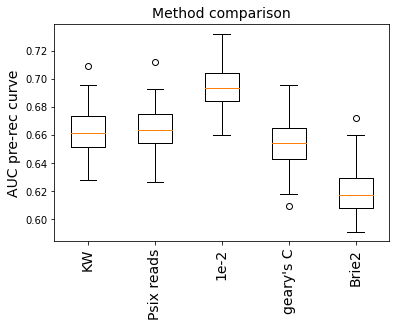

In [49]:
from sklearn.metrics import auc

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index
exons_pos = weyn_pos & exons
exons_neg = weyn_neg & exons


kw_auc = []
L_e2_auc = []
L_reads_auc = []

c_auc = []
brie_auc = []

for sample in tqdm(range(100)):
    pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
    neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)
    
    
    y = [1]*len(pd.Index(pos_choice) & tiklova_geary.index) + [0]*len(pd.Index(neg_choice) & tiklova_geary.index)
    c_y = list(tiklova_geary.loc[pd.Index(pos_choice) & tiklova_geary.index].C_score) + list(tiklova_geary.loc[pd.Index(neg_choice) & tiklova_geary.index].C_score)
    pre, rec, thres = precision_recall_curve(y, c_y)
    c_auc.append(auc(rec, pre))

    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list(tiklova_psix.loc[pos_choice].L_score) + list(tiklova_psix.loc[neg_choice].L_score)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    L_e2_auc.append(auc(rec, pre))
    
    
    
    kw_y = list(tiklova_kw.loc[pos_choice].KW_score) + list(tiklova_kw.loc[neg_choice].KW_score)
    pre, rec, thres = precision_recall_curve(y, kw_y)
    kw_auc.append(auc(rec, pre))
    
    r_y = list(tiklova_psix.loc[pos_choice].L_reads) + list(tiklova_psix.loc[neg_choice].L_reads)
    pre, rec, thres = precision_recall_curve(y, r_y)
    L_reads_auc.append(auc(rec, pre))
    
    y = [1]*len(pd.Index(pos_choice) & tiklova_brie.index) + [0]*len(pd.Index(neg_choice) & tiklova_brie.index)
    brie_y = list(tiklova_brie.loc[pd.Index(pos_choice) & tiklova_brie.index].neuro_ELBO_gain) + list(tiklova_brie.loc[pd.Index(neg_choice) & tiklova_brie.index].neuro_ELBO_gain)
    pre, rec, thres = precision_recall_curve(y, brie_y)
    brie_auc.append(auc(rec, pre))
    
    
bp = plt.boxplot(
    [kw_auc, L_reads_auc, L_e2_auc, c_auc, brie_auc]
)


plt.xticks(np.arange(1, 6), 
           ['KW', 'Psix reads', '1e-2', "geary's C", 'Brie2'], fontsize=14, rotation=90)

plt.ylabel('AUC pre-rec curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison', fontsize=14)


100%|██████████| 100/100 [00:02<00:00, 46.04it/s]


Text(0.5, 1.0, 'Method comparison')

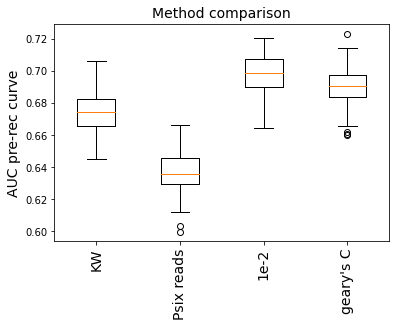

In [17]:
from sklearn.metrics import auc

hubbard_pos = hubbard_fdr.index[(hubbard_ds.max(axis=1) >= 0.2) & (hubbard_fdr.min(axis=1) <= 0.05)]
hubbard_neg = hubbard_fdr.index[(hubbard_ds.max(axis=1) < 0.2) | (hubbard_fdr.min(axis=1) > 0.05)]

exons = chen_psix.index
exons_pos = hubbard_pos & exons
exons_neg = hubbard_neg & exons


kw_auc = []
L_e2_auc = []
L_reads_auc = []

c_auc = []

for sample in tqdm(range(100)):
    pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
    neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)
    
    y = [1]*len(pd.Index(pos_choice) & chen_geary.index) + [0]*len(pd.Index(neg_choice) & chen_geary.index)
    c_y = list(chen_geary.loc[pd.Index(pos_choice) & chen_geary.index].C_score) + list(chen_geary.loc[pd.Index(neg_choice) & chen_geary.index].C_score)
    pre, rec, thres = precision_recall_curve(y, c_y)
    c_auc.append(auc(rec, pre))
    

    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list(chen_psix.loc[pos_choice].L_score) + list(chen_psix.loc[neg_choice].L_score)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    L_e2_auc.append(auc(rec, pre))
    
    
    kw_y = list(chen_kw.loc[pos_choice].KW_score) + list(chen_kw.loc[neg_choice].KW_score)
    pre, rec, thres = precision_recall_curve(y, kw_y)
    kw_auc.append(auc(rec, pre))
    
    r_y = list(chen_psix.loc[pos_choice].L_reads) + list(chen_psix.loc[neg_choice].L_reads)
    pre, rec, thres = precision_recall_curve(y, r_y)
    L_reads_auc.append(auc(rec, pre))
    
bp = plt.boxplot(
    [kw_auc, L_reads_auc, L_e2_auc, c_auc]
)


plt.xticks(np.arange(1, 5), 
           ['KW', 'Psix reads', '1e-2', "geary's C"], fontsize=14, rotation=90)

plt.ylabel('AUC pre-rec curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison', fontsize=14)


100%|██████████| 100/100 [00:02<00:00, 45.33it/s]


Text(0.5, 1.0, 'Method comparison')

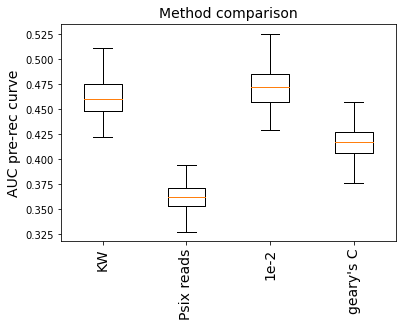

In [18]:
from sklearn.metrics import auc

song_bulk_pos = song_bulk_fdr.index[(song_bulk_ds.max(axis=1) >= 0.2) & (song_bulk_fdr.min(axis=1) <= 0.05)]
song_bulk_neg = song_bulk_fdr.index[(song_bulk_ds.max(axis=1) < 0.2) | (song_bulk_fdr.min(axis=1) > 0.05)]

exons = song_psix.index
exons_pos = song_bulk_pos & exons
exons_neg = song_bulk_neg & exons


kw_auc = []
L_e2_auc = []
L_reads_auc = []

c_auc = []

for sample in tqdm(range(100)):
    pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
    neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)
    
    y = [1]*len(pd.Index(pos_choice) & song_geary.index) + [0]*len(pd.Index(neg_choice) & song_geary.index)
    c_y = list(song_geary.loc[pd.Index(pos_choice) & song_geary.index].C_score) + list(song_geary.loc[pd.Index(neg_choice) & song_geary.index].C_score)
    pre, rec, thres = precision_recall_curve(y, c_y)
    c_auc.append(auc(rec, pre))

    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list(song_psix.loc[pos_choice].L_score) + list(song_psix.loc[neg_choice].L_score)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    L_e2_auc.append(auc(rec, pre))
    
    
    
    kw_y = list(song_kw.loc[pos_choice].KW_score) + list(song_kw.loc[neg_choice].KW_score)
    pre, rec, thres = precision_recall_curve(y, kw_y)
    kw_auc.append(auc(rec, pre))
    
    r_y = list(song_psix.loc[pos_choice].L_reads) + list(song_psix.loc[neg_choice].L_reads)
    pre, rec, thres = precision_recall_curve(y, r_y)
    L_reads_auc.append(auc(rec, pre))
    
bp = plt.boxplot(
    [kw_auc, L_reads_auc, L_e2_auc, c_auc]
)


plt.xticks(np.arange(1, 5), 
           ['KW', 'Psix reads', '1e-2', "geary's C"], fontsize=14, rotation=90)

plt.ylabel('AUC pre-rec curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison', fontsize=14)


plt.ylabel('AUC pre-rec curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison', fontsize=14)


In [16]:
tiklova_rd.index

Index(['SRR7408400', 'SRR7408401', 'SRR7408404', 'SRR7408413', 'SRR7408414',
       'SRR7408418', 'SRR7408422', 'SRR7408424', 'SRR7408426', 'SRR7408427',
       ...
       'SRR7410086', 'SRR7410088', 'SRR7410089', 'SRR7410090', 'SRR7410091',
       'SRR7410092', 'SRR7410093', 'SRR7410094', 'SRR7410096', 'SRR7410097'],
      dtype='object', length=1197)

In [17]:
chen_kw_scores_clusters

,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10
Aasdh_3,5.077451,5.077451,14.775475,14.775475,15.024270,15.449438,15.449438,15.449438,17.411836
Acadvl_1,0.661427,0.686903,0.703834,0.808916,0.906143,1.189424,1.632373,1.712662,2.786848
Actr3b_4,0.002622,0.407935,0.560645,4.916571,4.920745,4.997152,8.551775,12.237558,12.491957
Add1_7,0.111408,0.195250,2.063353,2.065354,2.066250,5.002097,7.090044,9.339802,11.458179
Add3_1,13.043792,57.174497,57.285195,114.264596,116.504871,116.882690,118.377948,126.706172,129.468968
...,...,...,...,...,...,...,...,...,...
Hnrnpa2b1_3,4.959284,5.619199,7.186211,10.116477,10.117927,10.344937,10.495916,10.552986,10.890511
Ndufa7_2,5.553817,16.389583,32.898703,61.693734,65.586765,65.619953,65.631353,65.881492,67.774941
Rps27l_2,28.598002,33.092956,33.096979,47.010571,59.481776,59.847422,60.249824,60.937344,61.643938
Srsf7_3,3.258289,8.400392,8.529937,9.134748,9.802634,12.193551,12.193636,21.350463,22.560926


100%|██████████| 100/100 [00:00<00:00, 311.67it/s]


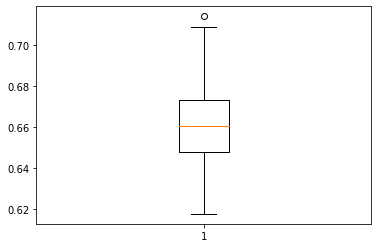

In [22]:
tiklova_kw_auc_list = []

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index
exons_pos = weyn_pos & exons
exons_neg = weyn_neg & exons


for clu in tiklova_kw_scores_clusters.columns:
    kw_auc = []
    
    for sample in tqdm(range(100)):
        pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
        neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)

        y = [1]*len(pos_choice) + [0]*len(neg_choice)
        kw_y = list(tiklova_kw_scores_clusters.loc[pos_choice][clu]) + list(tiklova_kw_scores_clusters.loc[neg_choice][clu])
        pre, rec, thres = precision_recall_curve(y, kw_y)
        kw_auc.append(auc(rec, pre))
        
    tiklova_kw_auc_list.append(kw_auc)

    


In [27]:
chen_kw_auc_list = []

hubbard_pos = hubbard_fdr.index[(hubbard_ds.max(axis=1) >= 0.2) & (hubbard_fdr.min(axis=1) <= 0.05)]
hubbard_neg = hubbard_fdr.index[(hubbard_ds.max(axis=1) < 0.2) | (hubbard_fdr.min(axis=1) > 0.05)]

exons = chen_psix.index
exons_pos = hubbard_pos & exons
exons_neg = hubbard_neg & exons


for clu in chen_kw_scores_clusters.columns:
    kw_auc = []
    
    for sample in tqdm(range(100)):
        pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
        neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)

        y = [1]*len(pos_choice) + [0]*len(neg_choice)
        kw_y = list(chen_kw_scores_clusters.loc[pos_choice][clu]) + list(chen_kw_scores_clusters.loc[neg_choice][clu])
        pre, rec, thres = precision_recall_curve(y, kw_y)
        kw_auc.append(auc(rec, pre))
        
    chen_kw_auc_list.append(kw_auc)

    


100%|██████████| 100/100 [00:00<00:00, 323.06it/s]


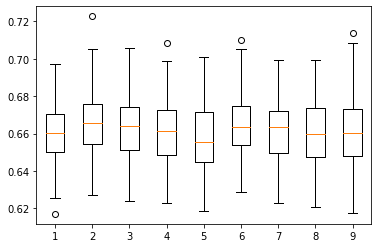

In [23]:
bp = plt.boxplot(
     tiklova_kw_auc_list
)

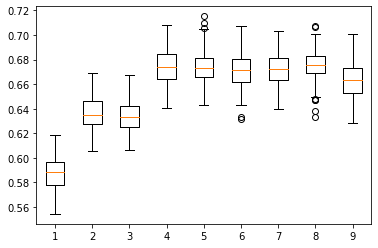

In [28]:
bp = plt.boxplot(
     chen_kw_auc_list
)

In [29]:
song_kw_auc_list = []

song_bulk_pos = song_bulk_fdr.index[(song_bulk_ds.max(axis=1) >= 0.2) & (song_bulk_fdr.min(axis=1) <= 0.05)]
song_bulk_neg = song_bulk_fdr.index[(song_bulk_ds.max(axis=1) < 0.2) | (song_bulk_fdr.min(axis=1) > 0.05)]

exons = song_psix.index
exons_pos = song_bulk_pos & exons
exons_neg = song_bulk_neg & exons


for clu in song_kw_scores_clusters.columns:
    kw_auc = []
    
    for sample in tqdm(range(100)):
        pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
        neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)

        y = [1]*len(pos_choice) + [0]*len(neg_choice)
        kw_y = list(song_kw_scores_clusters.loc[pos_choice][clu]) + list(song_kw_scores_clusters.loc[neg_choice][clu])
        pre, rec, thres = precision_recall_curve(y, kw_y)
        kw_auc.append(auc(rec, pre))
        
    song_kw_auc_list.append(kw_auc)

    


100%|██████████| 100/100 [00:00<00:00, 320.49it/s]


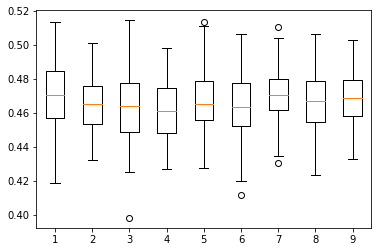

In [30]:
bp = plt.boxplot(
     song_kw_auc_list
)

In [20]:
# tiklova_kw_scores_clusters.to_csv('~/tiklova_kw_clusters.tab', sep='\t', index=True, header=True)
# chen_kw_scores_clusters.to_csv('~/chen_kw_clusters.tab', sep='\t', index=True, header=True)
# song_kw_scores_clusters.to_csv('~/song_kw_clusters.tab', sep='\t', index=True, header=True)

100%|██████████| 100/100 [00:01<00:00, 78.88it/s]


Text(0.5, 1.0, 'Method comparison')

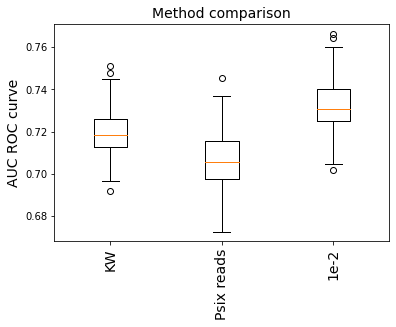

In [31]:
from sklearn.metrics import auc

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index
exons_pos = weyn_pos & exons
exons_neg = weyn_neg & exons


kw_auc = []
L_e2_auc = []
L_reads_auc = []

L_sum_auc = []

for sample in tqdm(range(100)):
    pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
    neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)

    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list(tiklova_psix.loc[pos_choice].L_score) + list(tiklova_psix.loc[neg_choice].L_score)
    rec, pre, thres = roc_curve(y, psix_y)
    L_e2_auc.append(auc(rec, pre))
    
    kw_y = list(tiklova_kw.loc[pos_choice].KW_score) + list(tiklova_kw.loc[neg_choice].KW_score)
    rec, pre, thres = roc_curve(y, kw_y)
    kw_auc.append(auc(rec, pre))
    
    r_y = list(tiklova_psix.loc[pos_choice].L_reads) + list(tiklova_psix.loc[neg_choice].L_reads)
    rec, pre, thres = roc_curve(y, r_y)
    L_reads_auc.append(auc(rec, pre))
    
bp = plt.boxplot(
    [kw_auc, L_reads_auc, L_e2_auc]
)


plt.xticks(np.arange(1, 4), 
           ['KW', 'Psix reads', '1e-2'], fontsize=14, rotation=90)

plt.ylabel('AUC ROC curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison', fontsize=14)


In [9]:
psix_k_pd = pd.DataFrame()
for k in [30, 35, 50, 150, 200, 300, 400]:

    print('K = ' + str(k))
    temp_W = W_tiklova = get_distance_matrix(tiklova_rd[['PC_1', 'PC_2']], k=k)
    L_list = []
    for exon in tqdm(tiklova_psix.index):
        L = px.calculate_exon_L(tiklova_PSI, temp_W, tiklova_mrna_event, exon, c = 0.1, 
                     randomize = False)
        L_list.append(L)

    psix_k_pd['k_' + str(k)] = L_list


  1%|▏         | 17/1197 [00:00<00:07, 168.15it/s]

K = 30


  0%|          | 0/1988 [00:00<?, ?it/s]../utils/psix_functions.py:129: RuntimeWarning: invalid value encountered in true_divide
  )/np.array(W.loc[cell_list, cell_list].sum(axis=1)))
 50%|████▉     | 993/1988 [01:57<03:00,  5.51it/s]../utils/psix_functions.py:69: RuntimeWarning: invalid value encountered in double_scalars
  return comb_1*comb_2*comb_3
 96%|█████████▌| 1904/1988 [04:24<00:26,  3.19it/s]../utils/psix_functions.py:69: RuntimeWarning: overflow encountered in double_scalars
  return comb_1*comb_2*comb_3
 96%|█████████▋| 1915/1988 [04:27<00:18,  4.05it/s]../utils/psix_functions.py:46: RuntimeWarning: overflow encountered in multiply
  prob_array = comb_1*comb_2*proba_1*proba_2
../utils/psix_functions.py:46: RuntimeWarning: invalid value encountered in multiply
  prob_array = comb_1*comb_2*proba_1*proba_2
  1%|          | 12/1197 [00:00<00:10, 115.93it/s]

K = 35


  0%|          | 0/1988 [00:00<?, ?it/s]../utils/psix_functions.py:129: RuntimeWarning: invalid value encountered in true_divide
  )/np.array(W.loc[cell_list, cell_list].sum(axis=1)))
 50%|████▉     | 993/1988 [01:56<02:55,  5.67it/s]../utils/psix_functions.py:69: RuntimeWarning: invalid value encountered in double_scalars
  return comb_1*comb_2*comb_3
 96%|█████████▌| 1904/1988 [04:18<00:21,  3.99it/s]../utils/psix_functions.py:69: RuntimeWarning: overflow encountered in double_scalars
  return comb_1*comb_2*comb_3
 96%|█████████▋| 1915/1988 [04:20<00:17,  4.25it/s]../utils/psix_functions.py:46: RuntimeWarning: overflow encountered in multiply
  prob_array = comb_1*comb_2*proba_1*proba_2
../utils/psix_functions.py:46: RuntimeWarning: invalid value encountered in multiply
  prob_array = comb_1*comb_2*proba_1*proba_2
  1%|          | 9/1197 [00:00<00:14, 82.67it/s]

K = 50


  0%|          | 0/1988 [00:00<?, ?it/s]../utils/psix_functions.py:129: RuntimeWarning: invalid value encountered in true_divide
  )/np.array(W.loc[cell_list, cell_list].sum(axis=1)))
 50%|████▉     | 993/1988 [01:56<03:27,  4.80it/s]../utils/psix_functions.py:69: RuntimeWarning: invalid value encountered in double_scalars
  return comb_1*comb_2*comb_3
 96%|█████████▌| 1904/1988 [04:22<00:25,  3.28it/s]../utils/psix_functions.py:69: RuntimeWarning: overflow encountered in double_scalars
  return comb_1*comb_2*comb_3
  0%|          | 4/1197 [00:00<00:36, 32.66it/s]

K = 150


 50%|████▉     | 993/1988 [01:56<02:57,  5.59it/s]../utils/psix_functions.py:69: RuntimeWarning: invalid value encountered in double_scalars
  return comb_1*comb_2*comb_3
 51%|█████     | 1007/1988 [01:58<02:33,  6.39it/s]../utils/psix_functions.py:129: RuntimeWarning: invalid value encountered in true_divide
  )/np.array(W.loc[cell_list, cell_list].sum(axis=1)))
 96%|█████████▌| 1904/1988 [04:19<00:20,  4.03it/s]../utils/psix_functions.py:69: RuntimeWarning: overflow encountered in double_scalars
  return comb_1*comb_2*comb_3
  0%|          | 3/1197 [00:00<00:47, 25.17it/s]

K = 200


 50%|████▉     | 993/1988 [01:56<03:35,  4.62it/s]../utils/psix_functions.py:69: RuntimeWarning: invalid value encountered in double_scalars
  return comb_1*comb_2*comb_3
 96%|█████████▌| 1904/1988 [04:20<00:25,  3.27it/s]../utils/psix_functions.py:69: RuntimeWarning: overflow encountered in double_scalars
  return comb_1*comb_2*comb_3
  0%|          | 0/1197 [00:00<?, ?it/s]

K = 300


 50%|████▉     | 993/1988 [01:58<03:40,  4.52it/s]../utils/psix_functions.py:69: RuntimeWarning: invalid value encountered in double_scalars
  return comb_1*comb_2*comb_3
 96%|█████████▌| 1904/1988 [04:24<00:26,  3.23it/s]../utils/psix_functions.py:69: RuntimeWarning: overflow encountered in double_scalars
  return comb_1*comb_2*comb_3
  0%|          | 0/1197 [00:00<?, ?it/s]

K = 400


 50%|████▉     | 993/1988 [01:57<03:37,  4.58it/s]../utils/psix_functions.py:69: RuntimeWarning: invalid value encountered in double_scalars
  return comb_1*comb_2*comb_3
 96%|█████████▌| 1904/1988 [04:22<00:20,  4.16it/s]../utils/psix_functions.py:69: RuntimeWarning: overflow encountered in double_scalars
  return comb_1*comb_2*comb_3
100%|██████████| 1988/1988 [04:43<00:00,  7.00it/s]


In [11]:
psix_k_pd.index = tiklova_psix.index

In [12]:
psix_k_pd

,k_30,k_35,k_50,k_150,k_200,k_300,k_400
Adap1_1,-0.018839,-0.007000,-0.013969,-0.005849,-0.010418,-0.008637,-0.008091
Aftph_4,-0.013502,-0.013900,-0.021077,-0.001778,0.000632,0.007008,0.010702
Agrn_8,0.011892,0.016140,0.025100,0.032033,0.030829,0.031437,0.033319
Agtpbp1_11,-0.043750,-0.049925,-0.039423,-0.006188,-0.006329,-0.004963,-0.002821
Aldh3a2_2,-0.041900,-0.039269,-0.034095,-0.014119,-0.008027,-0.010872,-0.012336
...,...,...,...,...,...,...,...
Mapt_1,2.329202,2.331960,2.327656,2.242984,2.195647,2.023024,1.691611
Meg3_2,0.286960,0.290233,0.301074,0.308858,0.309505,0.310224,0.307320
Nnat_2,0.617655,0.621530,0.622496,0.633542,0.625848,0.614538,0.593762
Nnat_3,0.556461,0.557040,0.559833,0.570559,0.564546,0.556413,0.535860


100%|██████████| 200/200 [00:01<00:00, 123.01it/s]


Text(0.5, 1.0, 'Method comparison')

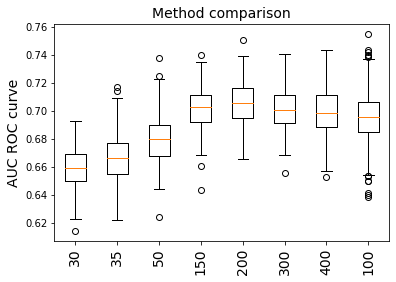

In [15]:
from sklearn.metrics import auc

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index
exons_pos = weyn_pos & exons
exons_neg = weyn_neg & exons


psix_auc_list = []
L_e2_auc = []
for k in psix_k_pd.columns:
    
    psix_auc = []

    for sample in tqdm(range(200)):
    
        pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
        neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)

    
       

        y = [1]*len(pos_choice) + [0]*len(neg_choice)
        psix_y = list(psix_k_pd.loc[pos_choice, k]) + list(psix_k_pd.loc[neg_choice, k])
        pre, rec, thres = precision_recall_curve(y, psix_y)
        psix_auc.append(auc(rec, pre))
        
        
        y = [1]*len(pos_choice) + [0]*len(neg_choice)
        psix_y = list(tiklova_psix.loc[pos_choice].L_score) + list(tiklova_psix.loc[neg_choice].L_score)
        pre, rec, thres = precision_recall_curve(y, psix_y)
        L_e2_auc.append(auc(rec, pre))
        
        
    psix_auc_list.append(psix_auc)
    
    
bp = plt.boxplot(
    psix_auc_list + [L_e2_auc]
)


plt.xticks(np.arange(1, 9), 
           ['30', '35', '50', '150', '200', '300', '400', '100'], fontsize=14, rotation=90)

plt.ylabel('AUC ROC curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison', fontsize=14)


In [30]:
tiklova_PSI.loc[tiklova_psix.index].isna().mean(axis=1).median()

0.5772765246449457

In [32]:
35/.25

140.0

In [3]:
chen_brie = pd.read_csv('~/data_sc_regulation/chen_extended/brie2/brie_output_ordered/brie_quant_cell.brie_ident.tsv', 
                           sep='\t', index_col=0)
chen_brie_pseudo = pd.read_csv('~/data_sc_regulation/chen_extended/brie2/brie_output_pseudotime/brie_quant_cell.brie_ident.tsv', 
                                  sep='\t', index_col=0)

tiklova_brie = pd.read_csv('~/data_sc_regulation/tiklova_extended/brie2/brie_output_ordered/brie_quant_cell.brie_ident.tsv', 
                           sep='\t', index_col=0)
tiklova_brie_pseudo = pd.read_csv('~/data_sc_regulation/tiklova_extended/brie2/brie_output_pseudotime/brie_quant_cell.brie_ident.tsv', 
                                  sep='\t', index_col=0)

In [8]:
tiklova_psix.loc[[x for x in tiklova_psix.index if 'Cadm1' in x]]

,bin,L_score,pvals,qvals,norm_pvals,norm_qvals
Cadm1_3,mean_2_var_5,1.162232,0.000999,0.003769,0.000000e+00,0.000000e+00
Cadm1_2,mean_4_var_1,0.141789,0.000999,0.003769,1.914609e-16,1.684178e-15
Cadm1_10,mean_4_var_2,1.416342,0.000999,0.003769,0.000000e+00,0.000000e+00
Cadm1_4,mean_4_var_2,0.225553,0.000999,0.003769,3.481713e-46,5.165406e-45


In [7]:
tiklova_brie.loc[[x for x in tiklova_brie.index if 'Cadm1' in x]]

,n_counts,n_counts_uniq,cdr,intercept,sigma,neuro_ceoff,neuro_ELBO_gain,neuro_pval,neuro_FDR
GeneID,,,,,,,,,
Cadm1_2,330444,68339,0.9566,-3.204,2.329,-0.70130,48.220,9.211000e-23,1.925000e-21
Cadm1_3,368201,13002,0.9591,-2.615,1.896,-0.68700,70.710,1.301000e-32,3.885000e-31
Cadm1_4,208963,60157,0.9490,-2.762,2.609,0.05805,2.078,4.148000e-02,8.584000e-02
Cadm1_9,176378,44883,0.9474,5.957,1.750,-0.47290,11.420,1.757000e-06,9.665000e-06
Cadm1_10,408608,53409,0.9616,3.772,1.554,-0.99940,227.800,4.238000e-101,8.858000e-99


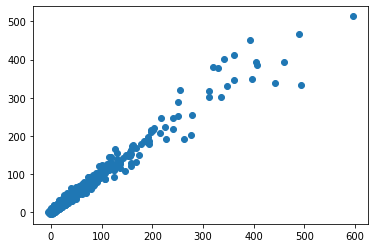

In [4]:
plt.scatter(tiklova_brie.neuro_ELBO_gain, tiklova_brie_pseudo.neuro_ELBO_gain)

In [32]:
tiklova_psix

,bin,L_score,pvals,qvals,norm_pvals,norm_qvals,L_reads
Adap1_1,mean_1_var_1,-0.006227,0.356643,0.488633,3.416702e-01,4.803680e-01,-0.016926
Aftph_4,mean_1_var_1,-0.004544,0.304695,0.439256,2.921742e-01,4.305725e-01,-0.039622
Agrn_8,mean_1_var_1,0.028174,0.000999,0.003769,5.728122e-04,2.198360e-03,-0.032576
Agtpbp1_11,mean_1_var_1,-0.014189,0.636364,0.753928,5.988674e-01,7.095044e-01,-0.032209
Aldh3a2_2,mean_1_var_1,-0.023037,0.836164,0.899510,8.369178e-01,8.888376e-01,-0.016152
...,...,...,...,...,...,...,...
Mapt_1,mean_4_var_4,2.289777,0.000999,0.003769,0.000000e+00,0.000000e+00,1.987172
Meg3_2,mean_5_var_1,0.308309,0.000999,0.003769,8.209725e-95,1.897783e-93,0.237332
Nnat_2,mean_5_var_1,0.634678,0.000999,0.003769,0.000000e+00,0.000000e+00,0.532083
Nnat_3,mean_5_var_1,0.571904,0.000999,0.003769,0.000000e+00,0.000000e+00,0.481867


In [18]:
from sklearn.metrics import auc

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index
exons_pos = weyn_pos & exons
exons_neg = weyn_neg & exons


kw_auc = []
L_e2_auc = []
# L_reads_auc = []

c_auc = []
brie_auc = []
briep_auc = []

for sample in tqdm(range(500)):
    pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
    neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)
    
    
    y = [1]*len(pd.Index(pos_choice) & tiklova_geary.index) + [0]*len(pd.Index(neg_choice) & tiklova_geary.index)
    c_y = list(tiklova_geary.loc[pd.Index(pos_choice) & tiklova_geary.index].C_score) + list(tiklova_geary.loc[pd.Index(neg_choice) & tiklova_geary.index].C_score)
    pre, rec, thres = precision_recall_curve(y, c_y)
    c_auc.append(auc(rec, pre))

    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list(tiklova_psix.loc[pos_choice].L_score) + list(tiklova_psix.loc[neg_choice].L_score)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    L_e2_auc.append(auc(rec, pre))
    
    
    
    kw_y = list(tiklova_kw.loc[pos_choice].KW_score) + list(tiklova_kw.loc[neg_choice].KW_score)
    pre, rec, thres = precision_recall_curve(y, kw_y)
    kw_auc.append(auc(rec, pre))
    
#     r_y = list(tiklova_psix.loc[pos_choice].L_reads) + list(tiklova_psix.loc[neg_choice].L_reads)
#     pre, rec, thres = precision_recall_curve(y, r_y)
#     L_reads_auc.append(auc(rec, pre))
    
    y = [1]*len(pd.Index(pos_choice) & tiklova_brie.index) + [0]*len(pd.Index(neg_choice) & tiklova_brie.index)
    brie_y = list(tiklova_brie.loc[pd.Index(pos_choice) & tiklova_brie.index].neuro_ELBO_gain) + list(tiklova_brie.loc[pd.Index(neg_choice) & tiklova_brie.index].neuro_ELBO_gain)
    pre, rec, thres = precision_recall_curve(y, brie_y)
    brie_auc.append(auc(rec, pre))
    
    y = [1]*len(pd.Index(pos_choice) & tiklova_brie_pseudo.index) + [0]*len(pd.Index(neg_choice) & tiklova_brie_pseudo.index)
    brie_y = list(tiklova_brie_pseudo.loc[pd.Index(pos_choice) & tiklova_brie.index].neuro_ELBO_gain) + list(tiklova_brie_pseudo.loc[pd.Index(neg_choice) & tiklova_brie.index].neuro_ELBO_gain)
    pre, rec, thres = precision_recall_curve(y, brie_y)
    briep_auc.append(auc(rec, pre))
    
    



100%|██████████| 500/500 [00:30<00:00, 16.41it/s]


Text(0.5, 1.0, 'Method comparison, Tiklova dataset')

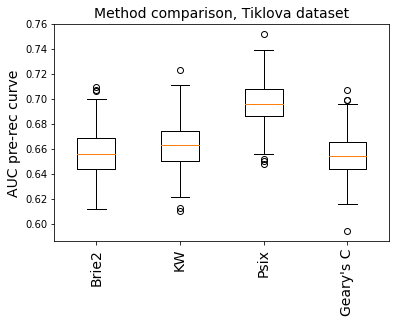

In [19]:
bp = plt.boxplot([brie_auc, kw_auc, L_e2_auc, c_auc])


plt.xticks(np.arange(1, 5), 
           ['Brie2', 'KW', 'Psix', "Geary's C"], fontsize=14, rotation=90)

plt.ylabel('AUC pre-rec curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison, Tiklova dataset', fontsize=14)

In [13]:
from sklearn.metrics import auc

hubbard_pos = hubbard_fdr.index[(hubbard_ds.max(axis=1) >= 0.2) & (hubbard_fdr.min(axis=1) <= 0.05)]
hubbard_neg = hubbard_fdr.index[(hubbard_ds.max(axis=1) < 0.2) | (hubbard_fdr.min(axis=1) > 0.05)]

exons = chen_psix.index
exons_pos = hubbard_pos & exons
exons_neg = hubbard_neg & exons


kw_auc = []
L_e2_auc = []
# L_reads_auc = []

c_auc = []
brie_auc = []
briep_auc = []

for sample in tqdm(range(500)):
    pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
    neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)
    
    
    y = [1]*len(pd.Index(pos_choice) & chen_geary.index) + [0]*len(pd.Index(neg_choice) & chen_geary.index)
    c_y = list(chen_geary.loc[pd.Index(pos_choice) & chen_geary.index].C_score) + list(chen_geary.loc[pd.Index(neg_choice) & chen_geary.index].C_score)
    pre, rec, thres = precision_recall_curve(y, c_y)
    c_auc.append(auc(rec, pre))

    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list(chen_psix.loc[pos_choice].L_score) + list(chen_psix.loc[neg_choice].L_score)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    L_e2_auc.append(auc(rec, pre))
    
    
    
    kw_y = list(chen_kw.loc[pos_choice].KW_score) + list(chen_kw.loc[neg_choice].KW_score)
    pre, rec, thres = precision_recall_curve(y, kw_y)
    kw_auc.append(auc(rec, pre))
    
#     r_y = list(chen_psix.loc[pos_choice].L_reads) + list(chen_psix.loc[neg_choice].L_reads)
#     pre, rec, thres = precision_recall_curve(y, r_y)
#     L_reads_auc.append(auc(rec, pre))
    
    y = [1]*len(pd.Index(pos_choice) & chen_brie.index) + [0]*len(pd.Index(neg_choice) & chen_brie.index)
    brie_y = list(chen_brie.loc[pd.Index(pos_choice) & chen_brie.index].neuro_ELBO_gain) + list(chen_brie.loc[pd.Index(neg_choice) & chen_brie.index].neuro_ELBO_gain)
    pre, rec, thres = precision_recall_curve(y, brie_y)
    brie_auc.append(auc(rec, pre))
    
    y = [1]*len(pd.Index(pos_choice) & chen_brie_pseudo.index) + [0]*len(pd.Index(neg_choice) & chen_brie_pseudo.index)
    brie_y = list(chen_brie_pseudo.loc[pd.Index(pos_choice) & chen_brie.index].neuro_ELBO_gain) + list(chen_brie_pseudo.loc[pd.Index(neg_choice) & chen_brie.index].neuro_ELBO_gain)
    pre, rec, thres = precision_recall_curve(y, brie_y)
    briep_auc.append(auc(rec, pre))
    
    



100%|██████████| 500/500 [00:27<00:00, 17.94it/s]


Text(0.5, 1.0, 'Method comparison, Chen dataset')

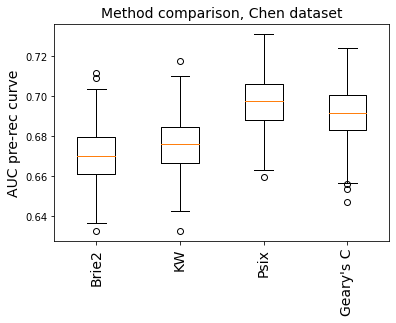

In [15]:
bp = plt.boxplot([briep_auc, kw_auc, L_e2_auc, c_auc])


plt.xticks(np.arange(1, 5), 
           ['Brie2', 'KW', 'Psix', "Geary's C"], fontsize=14, rotation=90)

plt.ylabel('AUC pre-rec curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison, Chen dataset', fontsize=14)

100%|██████████| 100/100 [00:02<00:00, 35.59it/s]


Text(0.5, 1.0, 'Method comparison, Tiklova dataset')

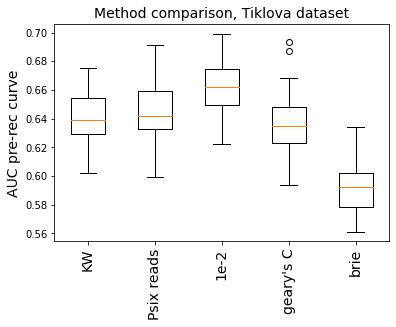

In [46]:
from sklearn.metrics import auc

hubbard_pos = hubbard_fdr.index[(hubbard_ds.max(axis=1) >= 0.2) & (hubbard_fdr.min(axis=1) <= 0.05)]
hubbard_neg = hubbard_fdr.index[(hubbard_ds.max(axis=1) < 0.2) | (hubbard_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index
exons_pos = hubbard_pos & exons
exons_neg = hubbard_neg & exons


kw_auc = []
L_e2_auc = []
L_reads_auc = []

c_auc = []

brie_auc = []

for sample in tqdm(range(100)):
    pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
    neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)
    
    y = [1]*len(pd.Index(pos_choice) & tiklova_geary.index) + [0]*len(pd.Index(neg_choice) & tiklova_geary.index)
    c_y = list(tiklova_geary.loc[pd.Index(pos_choice) & tiklova_geary.index].C_score) + list(tiklova_geary.loc[pd.Index(neg_choice) & tiklova_geary.index].C_score)
    pre, rec, thres = precision_recall_curve(y, c_y)
    c_auc.append(auc(rec, pre))
    

    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list(tiklova_psix.loc[pos_choice].L_score) + list(tiklova_psix.loc[neg_choice].L_score)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    L_e2_auc.append(auc(rec, pre))
    
    
    kw_y = list(tiklova_kw.loc[pos_choice].KW_score) + list(tiklova_kw.loc[neg_choice].KW_score)
    pre, rec, thres = precision_recall_curve(y, kw_y)
    kw_auc.append(auc(rec, pre))
    
    r_y = list(tiklova_psix.loc[pos_choice].L_reads) + list(tiklova_psix.loc[neg_choice].L_reads)
    pre, rec, thres = precision_recall_curve(y, r_y)
    L_reads_auc.append(auc(rec, pre))
    
    brie_y = list(-tiklova_brie.loc[pos_choice].neuro_pval) + list(-tiklova_brie.loc[neg_choice].neuro_pval)
    pre, rec, thres = precision_recall_curve(y, brie_y)
    brie_auc.append(auc(rec, pre))
    
bp = plt.boxplot(
    [kw_auc, L_reads_auc, L_e2_auc, c_auc, brie_auc]
)


plt.xticks(np.arange(1, 6), 
           ['KW', 'Psix reads', '1e-2', "geary's C", 'brie'], fontsize=14, rotation=90)

plt.ylabel('AUC pre-rec curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison, Tiklova dataset', fontsize=14)


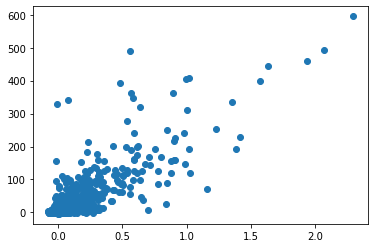

In [79]:
plt.scatter(
tiklova_psix.loc[tiklova_psix.index & tiklova_brie.index].L_score, 
    tiklova_brie.loc[tiklova_psix.index & tiklova_brie.index].neuro_ELBO_gain)

In [80]:
psix_max = tiklova_psix.loc[tiklova_psix.index & tiklova_brie.index].L_score.max()
psix_min = tiklova_psix.loc[tiklova_psix.index & tiklova_brie.index].L_score.min()
psix_adj = tiklova_psix.loc[tiklova_psix.index & tiklova_brie.index].L_score/(psix_max-psix_min)


brie_max = tiklova_brie.loc[tiklova_psix.index & tiklova_brie.index].neuro_ELBO_gain.max()
brie_min = tiklova_brie.loc[tiklova_psix.index & tiklova_brie.index].neuro_ELBO_gain.min()
brie_adj = tiklova_brie.loc[tiklova_psix.index & tiklova_brie.index].neuro_ELBO_gain/(brie_max-brie_min)

In [81]:
(psix_adj-brie_adj).sort_values()

Klc1_2     -0.579757
Nnat_7     -0.550623
Nnat_4     -0.533076
Nnat_6     -0.450731
Nnat_3     -0.360588
              ...   
Mbnl2_1     0.235846
Dst_5       0.263886
Micu1_4     0.285060
Camk2g_2    0.311260
Cadm1_3     0.373810
Length: 1987, dtype: float64

In [110]:
psi_o_array = tiklova_PSI.loc['Clta_4'].dropna()
cell_list = psi_o_array.index
psi_a_array = np.array(
        np.array(pd.DataFrame(
            np.array(W_tiklova.loc[cell_list, cell_list])*psi_o_array).sum(axis=1)
        )/np.array(W_tiklova.loc[cell_list, cell_list].sum(axis=1)))

Exception: Data must be 1-dimensional

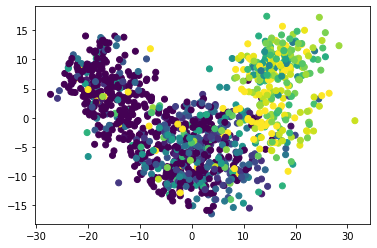

In [107]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc['Clta_4'])

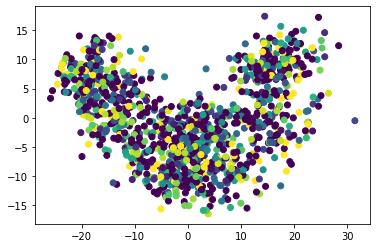

In [100]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, 
            c=np.random.choice(tiklova_PSI.loc['Clta_4'], len(tiklova_PSI.loc['Clta_4']), replace=False))

(array([508.,  57.,  92.,  66.,  53.,  59.,  55.,  67.,  70., 134.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

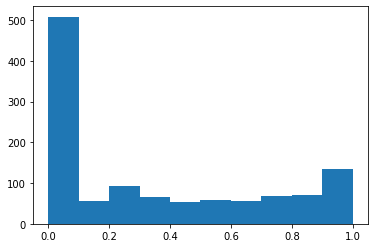

In [106]:
plt.hist(tiklova_PSI.loc['Clta_4'])